In [46]:

import os, math, io
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def get_nataraj_image_width(file_size_bytes: int) -> int:
    """Exact width mapping from Nataraj et al"""
    KB = 1024
    if file_size_bytes < 10 * KB:
        return 32
    elif file_size_bytes < 30 * KB:
        return 64
    elif file_size_bytes < 60 * KB:
        return 128
    elif file_size_bytes < 100 * KB:
        return 256
    elif file_size_bytes < 200 * KB:
        return 384
    elif file_size_bytes < 500 * KB:
        return 512
    elif file_size_bytes < 1000 * KB:
        return 768
    else:
        return 1024

def bytes_to_image_array(raw_bytes: bytes, width: int) -> np.ndarray:
    """
    Convert 1D bytes -> padded 2D uint8 array (height x width), row-major.
    Padding uses 0x00 at the end if needed to complete the final row.
    """
    data = np.frombuffer(raw_bytes, dtype=np.uint8)
    n = data.size
    height = math.ceil(n / width)
    needed = height * width

    if needed != n:
        pad = np.zeros(needed - n, dtype=np.uint8)
        data = np.concatenate([data, pad], axis=0)

    arr2d = data.reshape((height, width))
    return arr2d

def save_gray_png(arr2d: np.ndarray, out_path: str) -> None:
    img = Image.fromarray(arr2d.astype(np.uint8), mode="L")
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    img.save(out_path)

def visualize(arr2d: np.ndarray, title: str = None):
    plt.figure(figsize=(8, 8 * arr2d.shape[0] / max(1, arr2d.shape[1])))
    plt.imshow(arr2d, cmap="gray", vmin=0, vmax=255)
    plt.axis("off")
    if title:
        plt.title(title)
    plt.show()

def process_executable_file(filepath: str, out_dir: str = "nataraj_images", force_width: int | None = None,
                            show: bool = True) -> str:
    """
    Reads an EXE as bytes, picks Nataraj width (unless overridden), converts to 2D image,
    saves PNG, optionally displays it. Returns saved path.
    """
    with open(filepath, "rb") as f:
        raw = f.read()

    size = len(raw)
    width = force_width if force_width is not None else get_nataraj_image_width(size)
    arr2d = bytes_to_image_array(raw, width)

    base = os.path.splitext(os.path.basename(filepath))[0]
    out_path = os.path.join(out_dir, f"{base}_{width}x{arr2d.shape[0]}.png")
    save_gray_png(arr2d, out_path)

    print(f"[✓] File: {filepath}")
    print(f"    Size: {size} bytes ({size/1024:.2f} KB)")
    print(f"    Image shape: {arr2d.shape[0]} x {width} (H x W)")
    print(f"    Saved: {out_path}")

    if show:
        visualize(arr2d, title=os.path.basename(out_path))
    return out_path


Saving 64ae4c1107e5274b031a389bcf835593d5ace4fabae64724f2f57388b31330f5.exe to 64ae4c1107e5274b031a389bcf835593d5ace4fabae64724f2f57388b31330f5 (1).exe
[✓] File: /content/64ae4c1107e5274b031a389bcf835593d5ace4fabae64724f2f57388b31330f5 (1).exe
    Size: 956192 bytes (933.78 KB)
    Image shape: 1246 x 768 (H x W)
    Saved: nataraj_images/64ae4c1107e5274b031a389bcf835593d5ace4fabae64724f2f57388b31330f5 (1)_768x1246.png


/tmp/ipython-input-3729749807.py:44: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = Image.fromarray(arr2d.astype(np.uint8), mode="L")


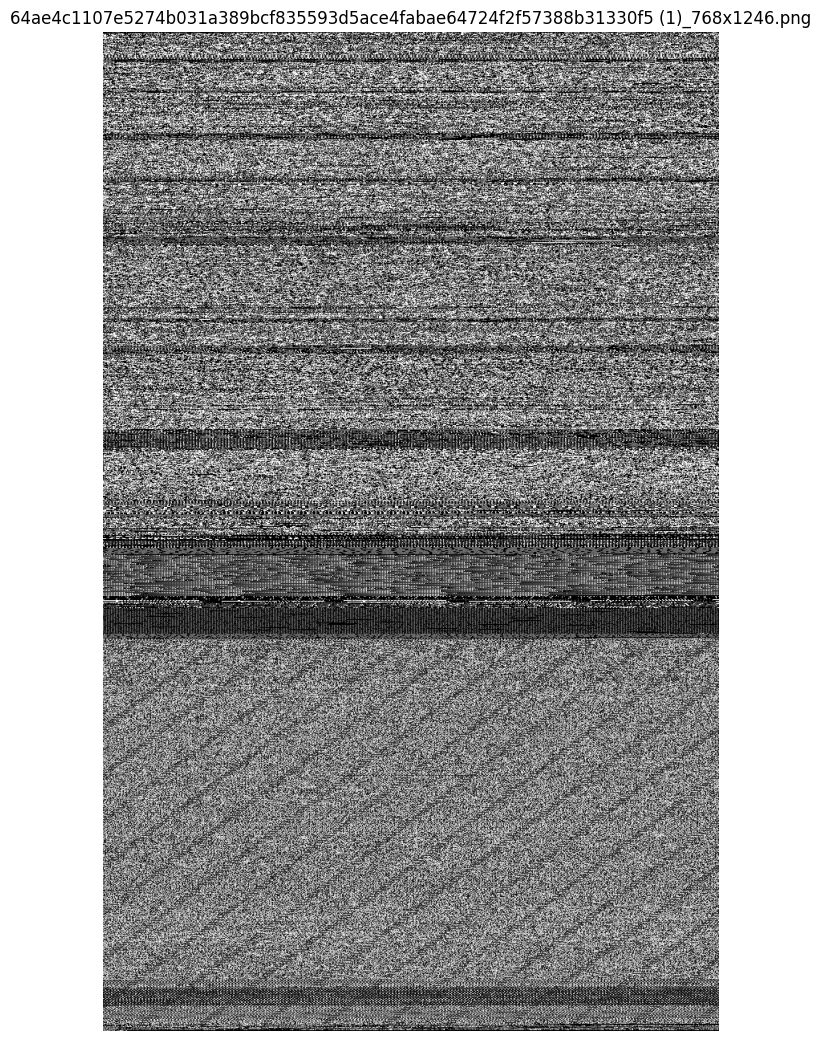


All done. Images saved here:
   nataraj_images/64ae4c1107e5274b031a389bcf835593d5ace4fabae64724f2f57388b31330f5 (1)_768x1246.png


In [47]:
# Upload .exe files
from google.colab import files
import os

uploaded = files.upload()  # pick one or multiple .exe files

converted_paths = []
for fname, content in uploaded.items():
    # Persist the uploaded file to disk
    in_path = os.path.abspath(fname)
    with open(in_path, "wb") as f:
        f.write(content)

    # Process -> PNG
    out_path = process_executable_file(in_path, out_dir="nataraj_images", force_width=None, show=True)
    converted_paths.append(out_path)

print("\nAll done. Images saved here:")
for p in converted_paths:
    print("  ", p)
